<h1><center>Programming Exercise 8:<br>Anomaly Detection and Recommender Systems</center></h1>

In [1]:
from scipy.io import loadmat
import numpy as np
from numpy.linalg import det, inv
import matplotlib.pyplot as plt
import matplotlib as mpl

# Global constants
pi = np.pi

mpl.rcParams['figure.figsize'] = (10,6)

# 1. Anomaly Detection
- Implement an anomaly detection algorithm to detect anomalous behavior in server computers. The features measure the throughput (mb/s) and latency (ms) of response of each server. We have collected $m=307$ samples of how they were behaving, thus giving us an unlabeled dataset $\{x^{(i)},\ldots,x^{(m)}\}$. We suspect that the vast majority of server samples are "normal" (non-anomalous) but there might also be some anomalous ones as well
- Use a Gaussian model to detect anomalous samples in the dataset. First on a 2D dataset to visualize it

## 1.1 Gaussian Distribution
- Load design matrix and labels:

In [2]:
data1 = loadmat('ex8data1.mat')
X, y = data1['X'], data1['yval'].flatten()

- Plot dataset scatter:

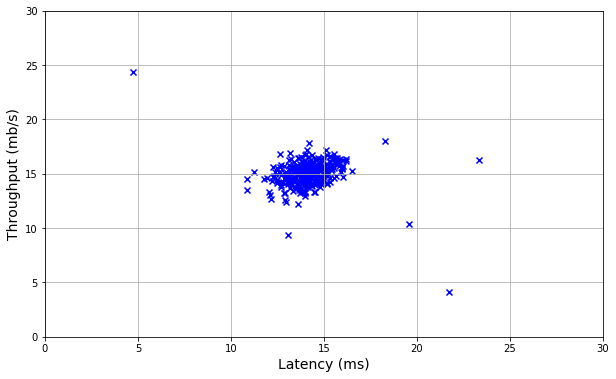

In [3]:
plt.figure()
plt.grid()
plt.scatter(X[:,0],X[:,1],marker='x',c='b')
plt.xlim(0,30)
plt.ylim(0,30)
plt.xlabel('Latency (ms)',fontsize=14)
plt.ylabel('Throughput (mb/s)',fontsize=14)
plt.show()

## 1.2 Estimating Parameters for a Gaussian
- Estimate the Gaussian parameters for each feature:

$$
\begin{split}
\mu_i & = \frac{1}{m}\sum_{j=1}^m x_i^{(j)}\\
\sigma_i^2 & = \frac{1}{m}\sum_{j=1}^m \left(x_i^{(j)}-\mu_i\right)^2
\end{split}
$$

In [4]:
def estimateGaussian(X):
    '''
    Estimates Gaussian distribution parameters mu and variance for each feature 
    
    Parameters
    ------------
    X: m by n design matrix
    
    Returns
    ------------
    mu: n-dimensional vector with means of features
    sigma: n-dimensional vector with variances of features
    '''    
    # Both methods use the 1/m convention for averaging by default
    mu = np.mean(X,axis=0) # average along columns
    sigma2 = np.std(X,axis=0) # std along column
    
    return mu, sigma2

- Estimate $\mu$ and $\sigma^2$:

In [5]:
mu, sigma2 = estimateGaussian(X)

- We'll be using a multi-variate (MVT) Gaussian distribution for the fit. Implement it such that if a the variable `sigma2` passed in is a matrix it will be treated as the covariance matrix 

$$
\begin{split}
\Sigma & = \frac{1}{m}\sum_{i=1}^m\left(x^{(i)}-\mu\right)\left(x^{(i)}-\mu\right)^T\\
 & = \frac{1}{m}\left(X-\mu\right)^T\cdot\left(X-\mu\right)
\end{split}
$$

for design matrix $X$ or if its a vector treated as the $\sigma^2$ values of the variances in each dimension, i.e a diagonal covariance matrix

$$
\Sigma = \text{diag}(\sigma_1^2,\ldots,\sigma_n^2)
$$

, either of shape $n\times n$, where the mean is defined as:

$$
\mu = \frac{1}{m}\sum_{i=1}^m x^{(i)}
$$

- Note that the MVT distribution probability (scalar) is defined $\it{per}$ sample vector $x^{(i)}$ as:

$$
p_i\left(x^{(i)};\mu,\Sigma\right) = \frac{1}{(2\pi)^{(n/2)}\det{\Sigma}^{1/2}}\exp\left(\frac{-1}{2}\left(x^{(i)}-\mu\right)^T\cdot\Sigma^{-1}\cdot\left(x^{(i)}-\mu\right)\right).
$$

Since we have $m$ such samples we'll have a vector $p$ of length $m$. To vectorize this we need to use a Hadamard (entrywise) product as well alongside matrix multiplocation. Each entry of the final p vector will have to be computed as a sum along the rows of the result of the previous (sentence) step. If we define the vector $\mathbf{e}$ as a vector with 1's for all entries and of approrpiate size (into whatever matrix its multiplying into) then we can write all this as:


$$
p\left(X;\mu,\Sigma\right)=\frac{1}{(2\pi)^{(n/2)}\det{\Sigma}^{1/2}}\exp\left(-\frac{1}{2}\mathbf{e}^T\cdot\left[\left(X-\mu\right) \circ \left[\Sigma^{-1} \cdot \left(X-mu\right)^T\right]^T\right]\cdot\mathbf{e}\right)
$$

In [33]:
def multivariateGaussian(X,mu,sigma2):
    '''
    Computes MVT Gaussian Distribution probabilities of samples in design matrix X
    
    Parameters
    ------------
    X: m by n design matrix
    mu: n-dimensional vector with means of features
    sigma2: n-dimensional vector with variances of features

    
    Returns
    ------------
    p: m-dimensional vector of MVT probability values of samples
    ''' 
    
    if (sigma2.ndim==1): # i.e if a vector
        sigma2 = np.diag(sigma2)
    
    n = mu.shape[0] # feature space dimension
    m = X.shape[0] # sample set size
    normalizing_factor = 1/((2*pi)**(n/2)*det(sigma2)**(0.5))
    
    exponential_arg = (X-mu)*((inv(sigma2)) @ (X-mu).T).T # will give matrix of shape m by n 
    if X.ndim != 1: # if there is more than one sample
        exponential_arg = np.sum(exponential_arg,axis=1) # sum along each row, now a vector of length m
    elif X.ndim == 1: # if there is only one sample
        exponential_arg = np.sum(exponential_arg,axis=0) # sum along the only row        
    density = np.exp(-0.5*exponential_arg)
    p = normalizing_factor * density # final probability vector
    
    return p

- Get the density of the MVT Distribution at each data point

In [34]:
p = multivariateGaussian(X,mu,sigma2)

- Now we need to show its contours so we need to compute the MTV on points on a grid:

In [32]:
sigma2.ndim

1

In [77]:
# Create a mesh to plot in
h = .05  # Step size in the mesh
x1_min, x1_max = 0, 30
x2_min, x2_max = 0, 30
x1_range, x2_range = np.meshgrid(np.arange(x1_min, x1_max, h),
                     np.arange(x2_min, x2_max, h))
grid_predict = np.empty((np.shape(x1_range)[0],np.shape(x1_range)[1])) # allocate space for the MTV over grid

# Since the function multivariateGaussian() was not written to expect and "x" and a "y" but rather a matrix X
# I can't call it directly with the mesh grid values. Rather I will loop through the values and evaluate it at each point
for idx_x1,ii_x1 in enumerate(x1_range[0,:]):
    for idx_x2,ii_x2 in enumerate(x2_range[:,0]):
        grid_predict[idx_x2][idx_x1] = multivariateGaussian(np.array([ii_x1,ii_x2]),mu,sigma2)

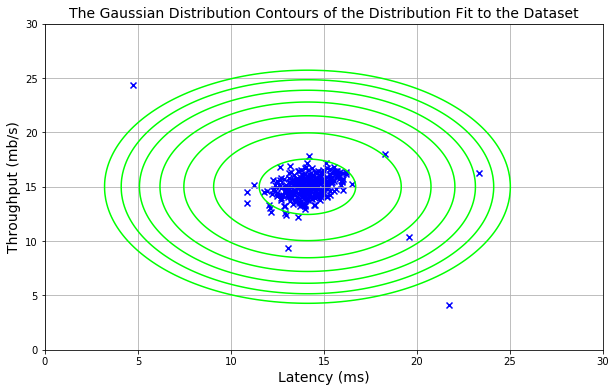

In [79]:
# Plot
plt.figure()
plt.grid(True)
cont_levels = [10**exp for exp in range(-20,0,3)]
CS = plt.contour(x1_range,x2_range,grid_predict,levels=cont_levels,colors='lime') # only plot where prediction = 0.5
#CS = plt.contour(x1_range,x2_range,grid_predict,10,colors='lime') # only plot where prediction = 0.5
plt.scatter(X[:,0],X[:,1],marker='x',c='b')
plt.xlim(0,30)
plt.ylim(0,30)
plt.xlabel('Latency (ms)',fontsize=14)
plt.ylabel('Throughput (mb/s)',fontsize=14)
plt.title('The Gaussian Distribution Contours of the Distribution Fit to the Dataset',fontsize=14)
plt.show()

- We can see that most of the examples are in the region with the highest probability, while the anomalous examples are in the regions with lower probabilities

## 1.3 Selecting the Threshold $\epsilon$

## 1.4 High-dimensioanl Dataset

# 2. Recommender Systems

## 2.1 Movie Ratings Dataset

## 2.2 Collaborative Filtering Algorithm

## 2.3 Learning Movie Recommendations